# 第 4 章   词频背后的语义


潜在语义分析（latent semantic analysis,LSA）:通过计算向量来表示词组合的意义。当使用该工具时，我们不仅可以把词的意义表示为向量，还可以用向量来表示整篇文档的意义。 
## 1.TF-IDF向量和主题向量
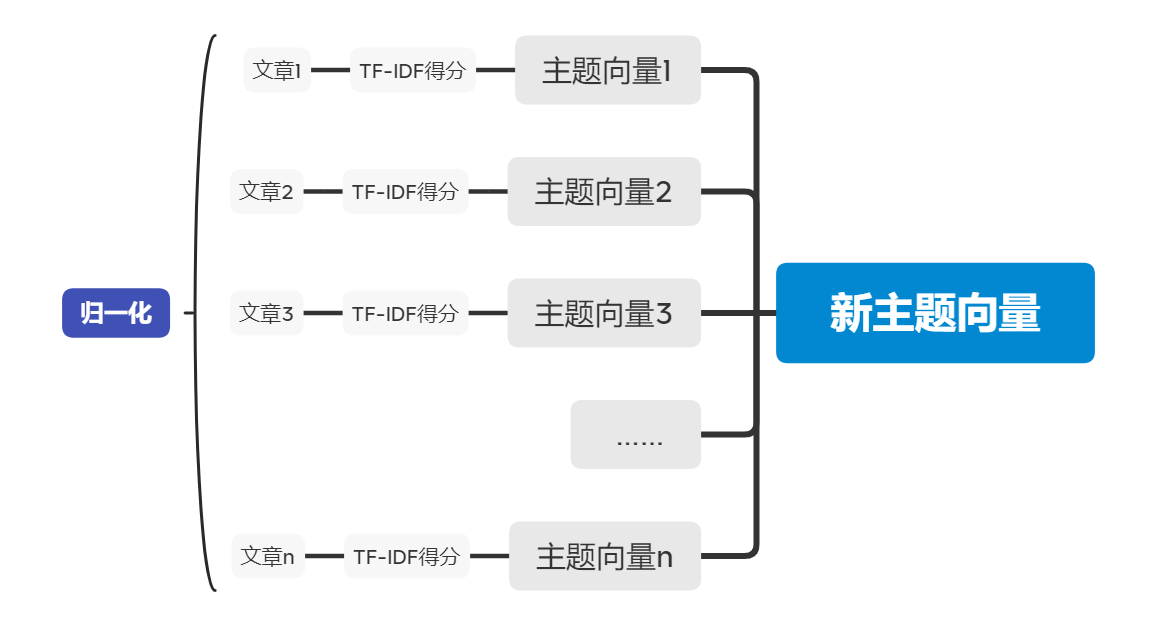

LSA可以处理的一词多义：

·同音异义（homonym）——词的拼写和发音相同，但含义不同； 

·轭式搭配（zeugma）——在同一句子中同时使用同一词的两种含义。 

在语音交互（可以语音交谈的聊天机器人，如Alexa或Siri）中的一词多义： 

·同形异义（homograph）——词的拼写相同，但是发音不同，含义不同； 

·同音异形（homophone）——词的发音相同，但是拼写不同，含义不同。

In [ ]:
>>> topic = {} 
>>> tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), 
...     np.random.rand(6)))) 
>>> topic['petness'] = (.3 * tfidf['cat'] +\ 
...                     .3 * tfidf['dog'] +\ 
...                      0 * tfidf['apple'] +\ 
...                      0 * tfidf['lion'] -\ 
...                     .2 * tfidf['NYC'] +\ 
...                     .2 * tfidf['love']) #人工设定的权重(0.3, 0.3, 0, 0, -0.2, 0.2)
乘以上面虚构的tfidf值，从而为虚构的随机文档创建主题向量。稍后我们将计算真实的主题向量 
>>> topic['animalness']  = (.1 * tfidf['cat'] +\ 
...                         .1 * tfidf['dog'] -\ 
...                         .1 * tfidf['apple'] +\ 
...                         .5 * tfidf['lion'] +\ 
...                         .1 * tfidf['NYC'] -\ 
...                         .1 * tfidf['love']) 
>>> topic['cityness']    = ( 0 * tfidf['cat'] -\ 
...                         .1 * tfidf['dog'] +\ 
...                         .2 * tfidf['apple'] -\ 
...                         .1 * tfidf['lion'] +\ 
...                         .5 * tfidf['NYC'] +\ 
...                         .1 * tfidf['love']) 

在上述思想实验中，我们把可能表示每个主题的词频加起来，并根据词与主题关联的可能性对词频（TF-IDF值）加权,对于那些可能在某种意义上与主题相反的词，我们对词频进行减法运算。
主题建模转换（颜色混合配方）是一个3×6的比例矩阵（权重），代表3个主题与6个词之间的关联。用这个矩阵乘以一个假想的6 × 1 TF-IDF向量，就得到了该文档的一个3×1的主题向量。
词和主题之间的关系可以翻转。3个主题向量组成的3 × 6矩阵可以转置，从而为词汇表中的每个词生成主题权重。这些权重向量就是6个词的词向量： 

In [ ]:
>>> word_vector = {} 
>>> word_vector['cat']  =  .3*topic['petness'] +\ 
...                        .1*topic['animalness'] +\ 
...                         0*topic['cityness'] 
>>> word_vector['dog']  =  .3*topic['petness'] +\ 
...                        .1*topic['animalness'] -\ 
...                        .1*topic['cityness'] 
>>> word_vector['apple']=   0*topic['petness'] -\ 
...                        .1*topic['animalness'] +\ 
...                        .2*topic['cityness'] 
>>> word_vector['lion'] =   0*topic['petness'] +\ 
...                        .5*topic['animalness'] -\ 
...                        .1*topic['cityness'] 
>>> word_vector['NYC']  = -.2*topic['petness'] +\ 
...                        .1*topic['animalness'] +\ 
...                        .5*topic['cityness'] 
>>> word_vector['love'] =  .2*topic['petness'] -\ 
...                        .1*topic['animalness'] +\ 
...                        .1*topic['cityness']  

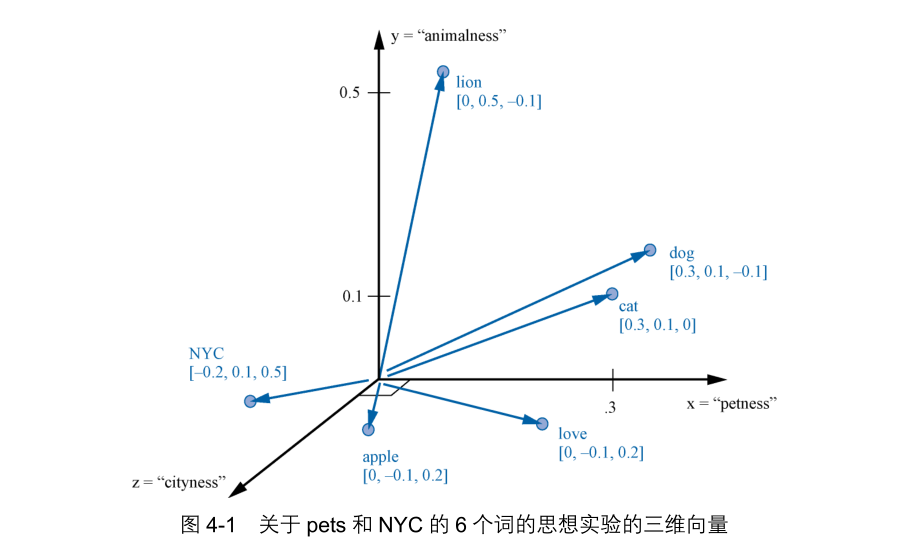

我们将六维（TF-IDF归一化频率）压缩为三维（主题）。n为词汇表中词项数，m为主题数，则：
权重矩阵(m×n)×TF-IDF向量(n×1)=主题向量(m×1)

## 2.主题评分算法
### LDA分类器
LDA分类器是一种有监督算法，因此需要对文档的类进行标注，但是它所需的训练样本数要比一些复杂的算法少得多。以下给出一个例子：

（1）计算某个类（如垃圾短消息类）中所有TF-IDF向量的平均位置（质心）。 

（2）计算不在该类（如非垃圾短消息类）中的所有TF-IDF向量的平均位置（质心）。 

（3）计算上述两个质心之间的向量差（即连接这两个向量的直线）。

In [ ]:
>>> import pandas as pd 
>>> from nlpia.data.loaders import get_data 
>>> pd.options.display.width = 120 
>>> sms = get_data('sms-spam') 
>>> index = ['sms{}{}'.format(i, '!'*j) for (i,j) in\ 
...     zip(range(len(sms)), sms.spam)] 
>>> sms = pd.DataFrame(sms.values, columns=sms.columns, index=index) 
>>> sms['spam'] = sms.spam.astype(int) 
>>> len(sms) 
>>> sms.spam.sum() 
>>> sms.head(6)
# 上述数据集中有4837条短消息，其中638条被标注为二类标签“spam”（垃圾类）。 下面我们就对所有这些短消息进行分词，并将它们转换为TF-IDF向量： 

In [ ]:
# 对短消息进行分词，将它们转换为TF-IDF向量：
>>> from sklearn.feature_extraction.text import TfidfVectorizer 
>>> from nltk.tokenize.casual import casual_tokenize 
>>> tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize) 
>>> tfidf_docs = tfidf_model.fit_transform(\ 
...     raw_documents=sms.text).toarray() 
>>> tfidf_docs.shape 
(4837, 9232) 
>>> sms.spam.sum() 
638  

In [ ]:
>>> mask = sms.spam.astype(bool).values 
>>> spam_centroid = tfidf_docs[mask].mean(axis=0) 
>>> ham_centroid = tfidf_docs[~mask].mean(axis=0) 
 
>>> spam_centroid.round(2) 
array([0.06, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]) 
>>> ham_centroid.round(2) 
array([0.02, 0.01, 0.  , ..., 0.  , 0.  , 0.  ]) 
#用一个质心向量减去另一个质心向量从而得到分类线：
>>> spamminess_score = tfidf_docs.dot(spam_centroid -\ 
...     ham_centroid) #该点积计算的是每个向量在质心连线上的“阴影”投影 
>>> spamminess_score.round(2) 
array([-0.01, -0.02, 0.04, ..., -0.01, -0. , 0. ])

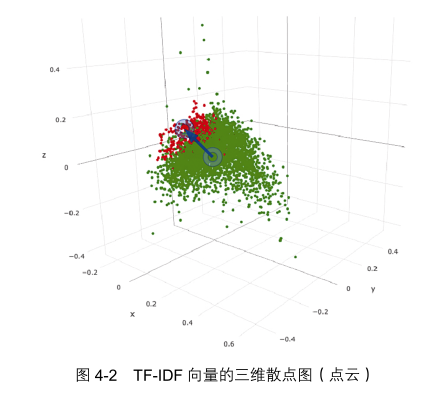
将上述评分取在0到1之间：

In [ ]:
>>> from sklearn.preprocessing import MinMaxScaler 
>>> sms['lda_score'] = MinMaxScaler().fit_transform(\ 
...     spamminess_score.reshape(-1,1)) 
>>> sms['lda_predict'] = (sms.lda_score > .5).astype(int) 
>>> sms['spam lda_predict lda_score'.split()].round(2).head(6) 
       spam lda_predict lda_score 
sms0      0           0      0.23 
sms1      0           0      0.18 
sms2!     1           1      0.72 
sms3      0           0      0.18 
sms4      0           0      0.29 
sms5!     1           1      0.55 

将阈值设置为50%时，该模型对97.7%的消息进行了正确分类。与朴素贝叶斯或对率回归模型不同，语义分析并不依赖独立的词。

## 3.潜在语义分析
当在自然语言处理中以这种方式使用SVD时，我们将其称为潜在语义分析（LSA），最好的变换方法是将坐标轴（维度）对齐到新向量中，使其在词频上具有最大的散度（spread）或方差（variance）。实验如下：

In [ ]:
>>> from nlpia.book.examples.ch04_catdog_lsa_3x6x16\ 
...     import word_topic_vectors 
>>> word_topic_vectors.T.round(1) 
      cat  dog  apple  lion  nyc  love 
top0 -0.6 -0.4    0.5  -0.3  0.4  -0.1 
top1 -0.1 -0.3   -0.4  -0.1  0.1   0.8 
top2 -0.3  0.8   -0.1  -0.5  0.0   0.1

奇异值分解是LSA背后的算法。

In [ ]:
>>> from nlpia.book.examples.ch04_catdog_lsa_sorted\ 
...     import lsa_models, prettify_tdm 
>>> bow_svd, tfidf_svd = lsa_models() 
>>> prettify_tdm(**bow_svd) 
   cat dog apple lion nyc love 
text 
0            1        1                                NYC is the Big Apple. 
1            1        1                       NYC is known as the Big Apple. 
2                     1    1                                     I love NYC! 
3            1        1          I wore a hat to the Big Apple party in NYC. 
4            1        1                      Come to NYC. See the Big Apple! 
5            1                            Manhattan is called the Big Apple. 
6    1                               New York is a big city for a small cat. 
7    1            1          The lion, a big cat, is the king of the jungle. 
8    1                     1                              I love my pet cat. 
9                     1    1                     I love New York City (NYC). 
10   1   1                                            Your dog chased mycat. 
#在词项-文档矩阵上使用SVD：
>>> tdm = bow_svd['tdm'] 
>>> tdm 
        0   1   2   3   4   5   6   7   8   9   10
cat     0   0   0   0   0   0   1   1   1   0    1 
dog     0   0   0   0   0   0   0   0   0   0    1 
apple   1   1   0   1   1   1   0   0   0   0    0 
lion    0   0   0   0   0   0   0   1   0   0    0 
nyc     1   1   1   1   1   0   0   0   0   1    0 
love    0   0   1   0   0   0   0   0   1   1    0 

SVD通过计算词项-文档矩阵的列（词项）之间的相关度来寻找那些同时出现的词，且能同时发现文档间词项使用的相关性和文档之间的相关性。利用这两条信息，SVD还可以计算出语料库中方差最大的词项的线性组合。

SVD将相关度高的词项组合在一起，同时这一组合在一组文档中出现的差异很大。我们认为这些词的线性组合就是主题。这些主题会将词袋向量（或TF-IDF向量）转换为主题向量，这些主题向量会给出文档的主题。

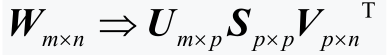

左奇异向量U：词项-主题矩阵，它给出词所具有的上下文信息，上例中为：
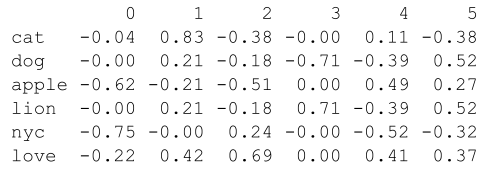
奇异值向量S：对角方阵，其对角线上的元素主题即“奇异值”，给出了在新的语义（主题）向量空间中每个维度所代表的信息量： 
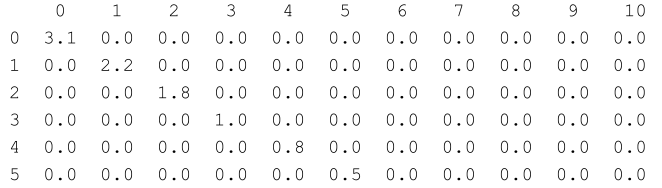
右奇异向量VT：文档-文档矩阵，其中每一列是“右奇异向量”。该矩阵将在文档之间提供共享语义，因为它度量了文档在新的文档语义模型中使用相同主题的频率：
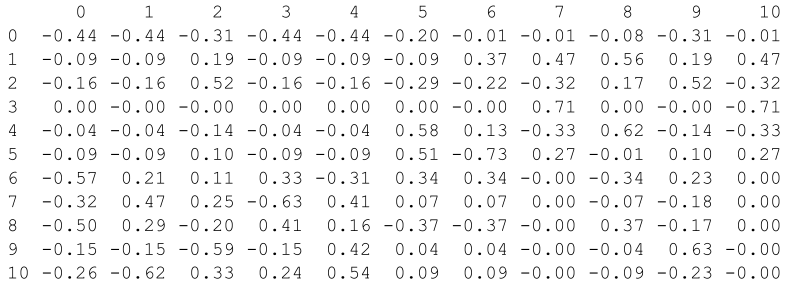

下面开始主题约简，直接去掉U右边的列，通过计算从主题-文档矩阵重构词项-文档矩阵的精确率来度量LSA的精确率：

In [ ]:
>>> err = [] 
>>> for numdim in range(len(s), 0, -1): 
...     S[numdim - 1, numdim - 1] = 0 
...     reconstructed_tdm = U.dot(S).dot(Vt) 
...     err.append(np.sqrt(((\ 
...         reconstructed_tdm - tdm).values.flatten() ** 2).sum() 
...         / np.product(tdm.shape))) 
>>> np.array(err).round(2) 
array([0.06, 0.12, 0.17, 0.28, 0.39, 0.55])

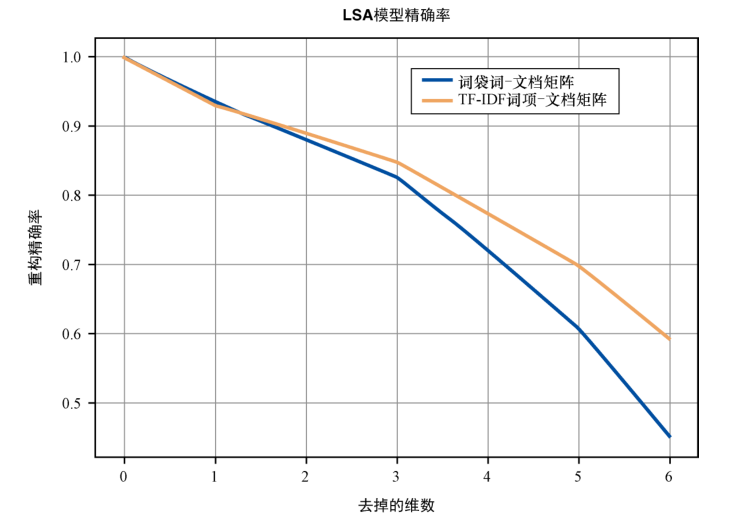
在上面的垃圾信息实验中，因为词库（或词汇表）中包含的独立词数，比短消息数还要多，训练集不均衡（8:1），存在过拟合现象，此时只需使用关键词的同义词就能轻松绕过过滤器。

降维是过拟合的主要应对措施。将多维度（词）合并到更少的维度（主题）中。

首先尝试scikit-learn中的PCA模型，把数据集9232维的TF-IDF向量转换为16维主题向量：

In [ ]:
>>> from sklearn.decomposition import PCA 
 
>>> pca = PCA(n_components=16) 
>>> pca = pca.fit(tfidf_docs) 
>>> pca_topic_vectors = pca.transform(tfidf_docs) 
>>> columns = ['topic{}'.format(i) for i in range(pca.n_components)] 
>>> pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns,\ 
...     index=index) 
>>> pca_topic_vectors.round(3).head(6) 
       topic0  topic1  topic2   ...     topic13  topic14  topic15 
sms0    0.201   0.003   0.037   ...      -0.026   -0.019    0.039 
sms1    0.404  -0.094  -0.078   ...      -0.036    0.047   -0.036 
sms2!  -0.030  -0.048   0.090   ...      -0.017   -0.045    0.057 
sms3    0.329  -0.033  -0.035   ...      -0.065    0.022   -0.076 
sms4    0.002   0.031   0.038   ...       0.031   -0.081   -0.021 
sms5!  -0.016   0.059   0.014   ...       0.077   -0.015    0.021 

In [ ]:
#探索一下tfidf.vocabulary，看看是否能找到那些“half off ”词项以及它们所属的主题： 
>>> pd.options.display.max_columns = 12 
>>> deals = weights['! ;] :] half off free crazy deal only $ 80 %'.split()]. 
    round(3) * 100 
>>> deals 
            !   ;)    :)  half  off  free  crazy  deal  only    $   80    % 
topic0   -7.1  0.1  -0.5  -0.0 -0.4  -2.0   -0.0  -0.1  -2.2  0.3 -0.0 -0.0 
topic1    6.3  0.0   7.4   0.1  0.4  -2.3   -0.2  -0.1  -3.8 -0.1 -0.0 -0.2 
topic2    7.1  0.2  -0.1   0.1  0.3   4.4    0.1  -0.1   0.7  0.0  0.0  0.1 
topic3   -5.9 -0.3  -7.1   0.2  0.3  -0.2    0.0   0.1  -2.3  0.1 -0.1 -0.3 
topic4   38.1 -0.1 -12.5  -0.1 -0.2   9.9    0.1  -0.2   3.0  0.3  0.1 -0.1 
topic5  -26.5  0.1  -1.5  -0.3 -0.7  -1.4   -0.6  -0.2  -1.8 -0.9  0.0  0.0 
topic6  -10.9 -0.5  19.9  -0.4 -0.9  -0.6   -0.2  -0.1  -1.4 -0.0 -0.0 -0.1 
topic7   16.4  0.1 -18.2   0.8  0.8  -2.9    0.0   0.0  -1.9 -0.3  0.0 -0.1 
topic8   34.6  0.1   5.2  -0.5 -0.5  -0.1   -0.4  -0.4   3.3 -0.6 -0.0 -0.2 
topic9    6.9 -0.3  17.4   1.4 -0.9   6.6   -0.5  -0.4   3.3 -0.4 -0.0  0.0 
... 
>>> deals.T.sum() 
topic0    -11.9 
topic1      7.5 
topic2     12.8 
topic3    -15.5 
topic4     38.3 
topic5    -33.8 
topic6      4.8 
topic7     -5.3 
topic8     40.5 
topic9     33.1 
... 

与deal相关的词可能对一些主题产生正向影响，而对另一些主题产生负向影响。并不存在一个明显的“deal”主题编号。

对主题的理解，就是LSA的挑战之一。LSA只允许词之间的线性关系。

然后在scikit-learn中试用一下TruncatedSVD模型，它可以处理稀疏矩阵，因此在处理大规模数据集时，使用它而非PCA。

In [ ]:
>>> from sklearn.decomposition import TruncatedSVD 
 
>>> svd = TruncatedSVD(n_components=16, n_iter=100) 
>>> svd_topic_vectors = svd.fit_transform(tfidf_docs.values) 
>>> svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns,\ 
...    index=index) 
>>> svd_topic_vectors.round(3).head(6) 
       topic0  topic1  topic2   ...     topic13  topic14  topic15 
sms0    0.201   0.003   0.037   ...      -0.036   -0.014    0.037 
sms1    0.404  -0.094  -0.078   ...      -0.021    0.051   -0.042 
sms2!  -0.030  -0.048   0.090   ...      -0.020   -0.042    0.052 
sms3    0.329  -0.033  -0.035   ...      -0.046    0.022   -0.070 
sms4    0.002   0.031   0.038   ...       0.034   -0.083   -0.021 
sms5!  -0.016   0.059   0.014   ...       0.075   -0.001    0.020
#计算对应文档对之间的余弦相似度
>>> import numpy as np 
 
>>> svd_topic_vectors = (svd_topic_vectors.T / np.linalg.norm(\ 
...     svd_topic_vectors, axis=1)).T 
>>> svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1) 
       sms0  sms1  sms2!  sms3  sms4  sms5!  sms6  sms7  sms8!  sms9! 
sms0    1.0   0.6   -0.1   0.6  -0.0   -0.3  -0.3  -0.1   -0.3   -0.3 
sms1    0.6   1.0   -0.2   0.8  -0.2    0.0  -0.2  -0.2   -0.1   -0.1 
sms2!  -0.1  -0.2    1.0  -0.2   0.1    0.4   0.0   0.3    0.5    0.4 
sms3    0.6   0.8   -0.2   1.0  -0.2   -0.3  -0.1  -0.3   -0.2   -0.1 
sms4   -0.0  -0.2    0.1  -0.2   1.0    0.2   0.0   0.1   -0.4   -0.2 
sms5!  -0.3   0.0    0.4  -0.3   0.2    1.0  -0.1   0.1    0.3    0.4 
sms6   -0.3  -0.2    0.0  -0.1   0.0   -0.1   1.0   0.1   -0.2   -0.2 
sms7   -0.1  -0.2    0.3  -0.3   0.1    0.1   0.1   1.0    0.1    0.4 
sms8!  -0.3  -0.1    0.5  -0.2  -0.4    0.3  -0.2   0.1    1.0    0.3 
sms9!  -0.3  -0.1    0.4  -0.1  -0.2    0.4  -0.2   0.4    0.3    1.0 

sms0和垃圾短消息（sms5!、sms6!、sms8!、sms9!）之间的余弦相似度是显著的负值，非垃圾短消息与垃圾短消息的主题向量有显著不同。

sms2!与其他垃圾短消息正相关。垃圾短消息具有相似的语义，它们谈论相似的“主题”。

这是语义搜索的工作原理。

无论使用哪种算法或具体实现来进行语义分析（LSA、PCA、SVD、截断的SVD或LDiA），都应该首先对词袋向量或TF-IDF向量进行归一化。

## 4.潜在狄利克雷分布（LDiA） 
LDiA和前面LSA（以及底层的SVD）一样做了很多创建主题模型的工作，但是与LSA不同的是，LDiA假设词频满足狄利克雷分布。相对于LSA的线性数学，LDiA则更精确地给出了将词赋给主题的统计信息。

在短消息实验中使用LDia：

In [ ]:
#使用LDiA为短消息语料库创建主题向量
>>> from sklearn.decomposition import LatentDirichletAllocation as LDiA 
 
>>> ldia = LDiA(n_components=16, learning_method='batch') 
>>> ldia = ldia.fit(bow_docs) 
>>> ldia.components_.shape 
(16, 9232)
#了解一些词是如何分配到主题中
>>> pd.set_option('display.width', 75) 
>>> components = pd.DataFrame(ldia.components_.T, index=terms,\ 
...     columns=columns) 
>>> components.round(2).head(3) 
       topic0  topic1  topic2   ...     topic13  topic14  topic15 
!      184.03   15.00   72.22   ...      297.29    41.16    11.70 
"        0.68    4.22    2.41   ...       62.72    12.27     0.06 
#        0.06    0.06    0.06   ...        4.05     0.06     0.06 
#感叹号（!）被分配到大多数主题中，但它其实是topic3中一个特别重要的部分，在该主题中引号（"）几乎不起作用。
>>> components.topic3.sort_values(ascending=False)[:10] 
!       394.952246 
.       218.049724 
to      119.533134 
u       118.857546 
call    111.948541 
£       107.358914 
,        96.954384 
*        90.314783 
your     90.215961 
is       75.750037 
#可以对主题的词分配进行合理化解释或推理。 
#为所有文档（短消息）计算出LDiA主题向量：
>>> ldia16_topic_vectors = ldia.transform(bow_docs) 
>>> ldia16_topic_vectors = pd.DataFrame(ldia16_topic_vectors,\ 
...     index=index, columns=columns) 
>>> ldia16_topic_vectors.round(2).head() 
       topic0  topic1  topic2   ...     topic13  topic14  topic15 
sms0     0.00    0.62    0.00   ...        0.00     0.00     0.00 
sms1     0.01    0.01    0.01   ...        0.01     0.01     0.01 
sms2!    0.00    0.00    0.00   ...        0.00     0.00     0.00 
sms3     0.00    0.00    0.00   ...        0.00     0.00     0.00 
sms4     0.39    0.00    0.33   ...        0.00     0.00     0.00 

然后使用LDiA主题向量来训练LDA模型：

In [ ]:
>>> from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
 
>>> X_train, X_test, y_train, y_test = 
➥ train_test_split(ldia16_topic_vectors, sms.spam, test_size=0.5, 
➥ random_state=271828) 
>>> lda = LDA(n_components=1) 
>>> lda = lda.fit(X_train, y_train) 
>>> sms['ldia16_spam'] = lda.predict(ldia16_topic_vectors) 
>>> round(float(lda.score(X_test, y_test)), 2) 
0.94 
#在测试集上取得94%的精确度

## 5.文档相似度
我们可以使用相似度评分（和距离），根据两篇文档的表示向量间的相似度（或距离）来判断文档间有多相似。

距离通常由相似度（分数）计算，典型的距离与相似度之间的换算公式如下：

In [ ]:
>>>similarity = 1. / (1. + distance) 
>>> distance = (1. / similarity) - 1.

但是，对于0到1之间（像概率一样）的距离和相似度得分，更常用的公式如下： 

In [ ]:
>>> similarity = 1. - distance 
>>> distance = 1. - similarity 

余弦相似度与余弦距离互为倒数： 

In [ ]:
>>> import math 
>>> angular_distance = math.acos(cosine_similarity) / math.pi 
>>> distance = 1. / similarity - 1. 
>>> similarity = 1. - distance

通过使用主题向量，我们可以比较词、文档、语句和语料库的含义，我们也可以找到相似文档和语句的“簇”。我们不再仅仅根据词的用法来比较文档之间的距离，也不再局限于完全基于词的选择或词汇表进行关键词搜索和相关性排名。